In [ ]:
from random import randint
import os
import math
import random
import gc
import pickle
import time
import torch
from numba import jit, cuda
import pandas as pd
import numpy as np
import json
import csv
import psutil
import nltk

In [ ]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import random
import os
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten,Embedding
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')
import math
import random
import gc
import pickle
import pandas as pd
import numpy as np
import re
import string
from os import listdir
from os.path import isfile,join
from tensorflow.keras.utils import to_categorical


# Making X-Y Pairs from File

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
X=np.load('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/X_id_without_sen_shuffle.npy')
Y=np.load('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/Y_id_without_sen_shuffle.npy').tolist()
one_h=np.load('/content/drive/MyDrive/Transformer_Experiments/OneHotEncoded.npy')

In [ ]:
file1=open('/content/drive/MyDrive/Transformer_Experiments/final_stopwords.txt')
stopwords=[]
for lines in file1.readlines():
  stopwords.append(lines[:-1])

In [ ]:
convert_file=open('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/wordtoid_without_sen_shuffle.json', 'r')
word2id=json.load(convert_file)
convert_file.close()
id2word=np.load('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/idtoword_without_sen_shuffle.npy')

In [ ]:
gc.collect()

58

In [ ]:
stopid=[]
for s in stopwords:
  if s in word2id:
    stopid.append(word2id[s])
  else:
    print(s)

अपने आप को
तुम्हारा
अपने आप
खुद को
कि वह
खुद ही
किसे
हूँ
होता है
किया जा रहा है
किया है
करता है
क्यूंकि
जब तक
के लिए
के बारे में
के माध्यम से
से पहले
के बाद
से नीचे
करने में
से अधिक
एक बार
यहाँ
वहाँ
कहाँ
में कुछ
में कोई
जरा
कर दिया
बड़ा
बड़े
उन्हें 
जिन्हों
तिन्हें
तिन्हों
किन्हों
किन्हें
इन्हों
उन्हों
बिलकुल
निहायत
जितना
साबुत
वग़ैरह
तिसे
काफ़ी
मानो
जीधर
तिस
तिन
संग
के द्वारा
के लिए
से 
रा
री
अरे
के बिना
होते हुए
यहाँ
हूँ
करेंग


In [ ]:
len(stopwords),len(stopid)

(298, 235)

In [ ]:
for i in range(len(Y)):
  for j,value in enumerate(Y[i]):
    Y[i][j]=one_h[value]
del one_h
gc.collect()

351

Credits- Major code for implementing the transformer in below section was taken from a tutorial published on tensorflow for NMT task from portugeuse to english using transformer. We have taken code of encoder part only for our task.

# Transformer_functions

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  matmul_qk=tf.cast(matmul_qk,dtype=tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  scaled_attention_logits=tf.cast(scaled_attention_logits,dtype=tf.float64)
  # add the mask to the scaled tensor.
  mask=None
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.models.Models([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn_0=tf.keras.layers.Dense(dff, activation='relu')
    self.ffn_1=tf.keras.layers.Dense(d_model)
 #   self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask,drp,layer_norm):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
#    if drp is not None:
#      attn_output = self.dropout1(attn_output, training=training)
    if layer_norm ==1:
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    else:
      out1 = x + attn_output  # (batch_size, input_seq_len, d_model)
    ffn_output = self.ffn_1(self.ffn_0(out1))  # (batch_size, input_seq_len, d_model)
    if drp is not None:
      ffn_output = self.dropout2(ffn_output, training=training)
    if layer_norm==1:
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    else:
      out2 = out1 + ffn_output  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
#    self.pred=tf.keras.layers.Dense(input_vocab_size)

  def call(self, x, training, mask,drp,layer_norm):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x=tf.cast(x,dtype=tf.float32)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

#    if drp is not None:
#      x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask,drp,layer_norm)
#    tf.shape(x)[0]
    x=tf.reshape(x,[tf.shape(x)[0],x.shape[1]*x.shape[2]])
#    print(x.shape)
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
def model_maker(seq_len_x,num_layers, d_model, num_heads, dff, input_vocab_size,
              target_vocab_size, pe_input, pe_target,op,layer_norm, droprate=0.1,Training=True):
  encoder = Encoder(num_layers, d_model, num_heads, dff,
                            input_vocab_size, pe_input, droprate)

  final_layer = tf.keras.layers.Dense(input_vocab_size,activation='softmax')

  # Keras models prefer if you pass all your inputs in the first argument
  inp= Input(shape=(seq_len_x), name='encoder_inputs')
  tar=inp
  print(inp.shape)
  print(droprate)
#  enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)

  enc_output = encoder(inp, Training, None,droprate,layer_norm)  # (batch_size, inp_seq_len, d_model)

  dense_output=final_layer(enc_output)
  dense_output=dense_output[:, np.newaxis,:]

  model_transformer = Model(inp,
                                                dense_output, name='model_transformer')
  model_transformer.compile(optimizer=op,loss='categorical_crossentropy', metrics=['accuracy'])
#  model_encoder_decoder_Bahdanau_Attention.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='categorical_crossentropy', metrics=['accuracy'])
  return model_transformer

# Calling transformer

In [ ]:
transformer = model_maker(
    seq_len_x=20,
    num_layers=4,
    d_model=128,
    num_heads=4,
    dff=2048,
    input_vocab_size=10767,
    target_vocab_size=10000,
    pe_input=1000,
    pe_target=1000,
    op=tf.keras.optimizers.Adam(learning_rate=0.001),layer_norm=0,droprate=None)

(None, 20)
None


In [ ]:
transformer.summary()

Model: "model_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 20)]             0         
                                                                 
 encoder (Encoder)           (None, 2560)              3748224   
                                                                 
 dense_24 (Dense)            (None, 10767)             27574287  
                                                                 
 tf.__operators__.getitem (S  (None, 1, 10767)         0         
 licingOpLambda)                                                 
                                                                 
Total params: 31,322,511
Trainable params: 31,322,511
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('RAM memory % used:', psutil.virtual_memory()[2])

In [ ]:
a=len(X)/54400

In [ ]:
int(a-a*0.1-2)

190

In [ ]:
validation_X=X[54400*int(a-a*0.1-2):54400*int(a-a*0.1-2)+10000]
validation_Y=np.array(Y[54400*int(a-a*0.1-2):54400*int(a-a*0.1-2)+10000])

In [ ]:
p=json.loads('{"validation_accuracies_upto_i-th_sample": [0.1578, 0.2162, 0.2288, 0.2416, 0.2494, 0.2506, 0.2522, 0.263, 0.2694, 0.2773, 0.2715, 0.284, 0.2878, 0.2852, 0.2911, 0.2912, 0.2923, 0.3031, 0.2961, 0.2999, 0.3048, 0.3055, 0.3106, 0.3142, 0.3147, 0.3121, 0.3172, 0.3191, 0.317, 0.3196, 0.3153, 0.3215, 0.3176, 0.3238, 0.3223, 0.3278, 0.3153, 0.328, 0.3317, 0.3294, 0.3307, 0.3273, 0.33, 0.3305, 0.3363, 0.3346, 0.3361, 0.3371, 0.3342, 0.3387, 0.3398, 0.3408, 0.3414, 0.3464, 0.3445, 0.3467, 0.3487, 0.3472, 0.3483, 0.3465, 0.346, 0.3491, 0.3491, 0.3462, 0.3475, 0.3499, 0.3513, 0.3525, 0.3532, 0.3548, 0.3532, 0.3518, 0.3561, 0.3547, 0.3546, 0.3541, 0.3509, 0.3496, 0.3552, 0.3543, 0.3574, 0.3543, 0.3534, 0.3524, 0.356, 0.3491, 0.3584, 0.3603, 0.3603, 0.3606, 0.3661, 0.3629, 0.3618, 0.3578, 0.3604, 0.3547]}')
len(p['validation_accuracies_upto_i-th_sample'])

96

In [ ]:
transformer.load_weights('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/Experimentdone on 27 3 22 without sen shuffle 4:57pm/weights_transformer')

In [ ]:
transformer.evaluate(validation_X,validation_Y,batch_size=1024)

10/10 [==============================] - 7s 121ms/step - loss: 3.3483 - accuracy: 0.3738


[3.348339022445679, 0.3738]

In [ ]:
p={}
p['validation_accuracies_upto_i-th_sample']=[]


In [ ]:
segment=0

In [ ]:
for i in range(int(a-a*0.1-2)):
#  segment=random.randint(20,300)
  l=54400*segment
  u=54400*(segment+1)
  X_10_1=X[l:u]
  Y_10_1=np.array(Y[l:u])
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)
  history=transformer.fit(X_10_1,Y_10_1,batch_size=1024,epochs=30,validation_data=(validation_X,validation_Y),callbacks=[callback])
#  transformer.save_weights("/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/weights_transformer")
#  p['validation_accuracies_upto_i-th_sample'].append(max(history.history['val_accuracy']))
#  ar_file=open('/content/drive/MyDrive/Transformer_Experiments/20,1,X,Y/val_acc.json', 'w')
#  json.dump(p,ar_file)
#  ar_file.seek(0)
#  ar_file.close()
  gc.collect()
  del X_10_1
  del Y_10_1
  del history
  gc.collect()
  print('RAM memory % used:', psutil.virtual_memory()[2])
  print(color.BOLD+"cou={},i={} done".format(segment,i+1)+color.END)
  segment+=1
  if segment<int(a-a*0.1-2):
    continue
  else:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


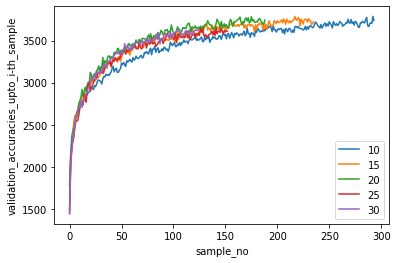

In [ ]:
#Finding best input sentence length size
po10=json.loads('{"validation_accuracies_upto_i-th_sample": [0.1782, 0.2119, 0.2347, 0.2422, 0.2463, 0.2566, 0.2577, 0.2639, 0.2653, 0.27, 0.2736, 0.273, 0.2747, 0.2773, 0.283, 0.2843, 0.2857, 0.2854, 0.2884, 0.289, 0.2911, 0.2943, 0.2938, 0.2917, 0.2964, 0.2952, 0.2982, 0.3025, 0.3031, 0.3022, 0.3013, 0.2984, 0.3044, 0.3075, 0.3067, 0.3099, 0.3086, 0.3098, 0.3086, 0.3107, 0.3127, 0.3166, 0.3196, 0.3128, 0.3157, 0.3171, 0.3122, 0.3124, 0.315, 0.3165, 0.3233, 0.3212, 0.3239, 0.3217, 0.3192, 0.326, 0.3245, 0.3257, 0.3278, 0.3255, 0.3244, 0.3297, 0.3267, 0.3277, 0.3314, 0.3292, 0.3287, 0.3295, 0.3314, 0.3325, 0.3293, 0.33, 0.3357, 0.3349, 0.3369, 0.335, 0.334, 0.3384, 0.3408, 0.3331, 0.3398, 0.3397, 0.343, 0.3361, 0.3395, 0.3414, 0.3356, 0.3378, 0.3375, 0.3402, 0.3379, 0.3421, 0.3414, 0.3387, 0.3399, 0.3371, 0.341, 0.348, 0.3461, 0.3438, 0.3461, 0.3475, 0.3429, 0.3428, 0.3459, 0.3442, 0.3476, 0.3441, 0.3476, 0.3473, 0.3507, 0.348, 0.349, 0.3491, 0.3463, 0.3498, 0.3529, 0.3508, 0.3505, 0.3518, 0.3526, 0.3559, 0.3503, 0.3519, 0.3502, 0.3512, 0.3523, 0.3542, 0.3489, 0.3487, 0.3545, 0.3508, 0.3533, 0.3523, 0.3548, 0.3479, 0.3508, 0.3515, 0.3548, 0.3528, 0.3539, 0.352, 0.3515, 0.3528, 0.3559, 0.3552, 0.3514, 0.3553, 0.3593, 0.3564, 0.3571, 0.3521, 0.3575, 0.3584, 0.3527, 0.3558, 0.3594, 0.3566, 0.3532, 0.3585, 0.3571, 0.3591, 0.3579, 0.3553, 0.3572, 0.3578, 0.3563, 0.3585, 0.3612, 0.3558, 0.3575, 0.3646, 0.3582, 0.3584, 0.3538, 0.3593, 0.3578, 0.3586, 0.3548, 0.3621, 0.3597, 0.3644, 0.3629, 0.3604, 0.3605, 0.3618, 0.3606, 0.3635, 0.3615, 0.364, 0.3636, 0.3649, 0.367, 0.3657, 0.3648, 0.3605, 0.3679, 0.3625, 0.3632, 0.36, 0.3621, 0.3639, 0.3631, 0.3642, 0.3643, 0.3594, 0.3629, 0.3578, 0.3642, 0.3628, 0.3604, 0.3641, 0.3644, 0.3617, 0.3595, 0.3625, 0.3597, 0.3666, 0.3667, 0.3652, 0.3668, 0.3645, 0.3642, 0.3638, 0.3637, 0.3623, 0.3636, 0.3669, 0.3626, 0.3662, 0.3636, 0.3671, 0.3678, 0.3665, 0.3651, 0.3661, 0.3698, 0.3718, 0.3699, 0.3676, 0.3666, 0.3648, 0.3691, 0.3648, 0.3672, 0.3695, 0.3708, 0.3669, 0.3699, 0.3673, 0.3724, 0.37, 0.3682, 0.3649, 0.3724, 0.3695, 0.3682, 0.37, 0.3678, 0.3689, 0.3725, 0.3713, 0.3702, 0.3669, 0.3686, 0.3688, 0.371, 0.3704, 0.3754, 0.3711, 0.3706, 0.375, 0.3703, 0.372, 0.3682, 0.3727, 0.3718, 0.3692, 0.3658, 0.3657, 0.3711, 0.3707, 0.373, 0.3714, 0.3709, 0.3746, 0.3774, 0.3675, 0.3666, 0.37, 0.3712, 0.3703, 0.3787, 0.3736]}')
po15=json.loads('{"validation_accuracies_upto_i-th_sample": [0.1597, 0.2115, 0.2179, 0.2364, 0.2514, 0.2607, 0.2614, 0.2641, 0.268, 0.2752, 0.2753, 0.2769, 0.2824, 0.2885, 0.2788, 0.2926, 0.2925, 0.2974, 0.2949, 0.2957, 0.2944, 0.3077, 0.3009, 0.304, 0.3019, 0.3041, 0.3139, 0.3057, 0.307, 0.3081, 0.3145, 0.3181, 0.3173, 0.3114, 0.3174, 0.3183, 0.3171, 0.3233, 0.3219, 0.3278, 0.3215, 0.3229, 0.3267, 0.3287, 0.3286, 0.3282, 0.3246, 0.3304, 0.3315, 0.3251, 0.3302, 0.3336, 0.3377, 0.3372, 0.3383, 0.335, 0.34, 0.3358, 0.3327, 0.3381, 0.3385, 0.3398, 0.3448, 0.3425, 0.3431, 0.3418, 0.3402, 0.3474, 0.3461, 0.3436, 0.3438, 0.3415, 0.3461, 0.3454, 0.3484, 0.3451, 0.35, 0.346, 0.3474, 0.3496, 0.3514, 0.3508, 0.3479, 0.3562, 0.3517, 0.3554, 0.3528, 0.3504, 0.3514, 0.3522, 0.3512, 0.3545, 0.3503, 0.3506, 0.3514, 0.3501, 0.3507, 0.3528, 0.3512, 0.3566, 0.3543, 0.3491, 0.3482, 0.3535, 0.3593, 0.3512, 0.3587, 0.3563, 0.3581, 0.3527, 0.3564, 0.357, 0.3567, 0.3545, 0.3554, 0.3554, 0.3623, 0.3587, 0.3649, 0.3607, 0.3608, 0.357, 0.3579, 0.3554, 0.3597, 0.3646, 0.3603, 0.3626, 0.3591, 0.3631, 0.3678, 0.367, 0.369, 0.3625, 0.3653, 0.3635, 0.3612, 0.3682, 0.3655, 0.3652, 0.3623, 0.3601, 0.3668, 0.3647, 0.3626, 0.3691, 0.3672, 0.3644, 0.3653, 0.3702, 0.3614, 0.3642, 0.3658, 0.3647, 0.3684, 0.3694, 0.37, 0.3685, 0.3727, 0.3669, 0.3678, 0.3674, 0.3691, 0.3667, 0.3686, 0.3697, 0.3701, 0.3717, 0.3648, 0.3686, 0.3644, 0.3676, 0.3692, 0.3696, 0.3671, 0.369, 0.368, 0.3663, 0.3602, 0.3686, 0.3637, 0.3687, 0.3684, 0.3707, 0.3693, 0.3711, 0.3623, 0.3679, 0.3647, 0.3694, 0.3638, 0.3679, 0.3734, 0.3696, 0.3666, 0.368, 0.3675, 0.3736, 0.3721, 0.37, 0.3737, 0.3715, 0.3715, 0.3724, 0.3744, 0.371, 0.3756, 0.373, 0.3694, 0.3755, 0.3727, 0.3709, 0.3737, 0.3712, 0.3727, 0.3734, 0.375, 0.3785, 0.3745, 0.374, 0.3772, 0.3754, 0.3673, 0.3756, 0.3722, 0.3696, 0.3752, 0.3752, 0.3749, 0.3717, 0.3758, 0.3738, 0.3732, 0.369, 0.3704, 0.3723]}')
po20=json.loads('{"validation_accuracies_upto_i-th_sample": [0.1502, 0.2025, 0.2252, 0.2298, 0.2461, 0.2488, 0.2581, 0.2636, 0.2688, 0.2757, 0.279, 0.2829, 0.2919, 0.2845, 0.2888, 0.2945, 0.2899, 0.2968, 0.299, 0.3004, 0.3121, 0.3091, 0.3033, 0.3075, 0.3105, 0.3082, 0.3143, 0.3158, 0.3198, 0.3119, 0.3187, 0.3181, 0.33, 0.3173, 0.326, 0.3237, 0.3259, 0.331, 0.3319, 0.3291, 0.331, 0.3286, 0.3299, 0.3361, 0.3348, 0.3343, 0.3403, 0.3407, 0.3338, 0.3379, 0.3384, 0.3373, 0.3402, 0.3404, 0.3387, 0.3419, 0.3448, 0.3466, 0.3435, 0.3448, 0.3429, 0.3462, 0.3454, 0.3469, 0.3506, 0.3473, 0.3467, 0.3514, 0.348, 0.3507, 0.3525, 0.3525, 0.3519, 0.3519, 0.3509, 0.354, 0.3565, 0.3523, 0.3582, 0.3523, 0.3521, 0.3559, 0.3523, 0.3527, 0.3564, 0.3596, 0.3561, 0.3568, 0.3619, 0.3605, 0.3568, 0.3578, 0.3625, 0.3623, 0.363, 0.359, 0.3609, 0.3603, 0.3685, 0.3623, 0.3596, 0.3564, 0.3588, 0.3623, 0.3664, 0.3625, 0.3594, 0.3592, 0.3608, 0.3653, 0.3643, 0.3651, 0.3641, 0.3678, 0.37, 0.3707, 0.3665, 0.3605, 0.3663, 0.3648, 0.365, 0.3674, 0.3642, 0.3652, 0.3658, 0.3642, 0.3671, 0.3624, 0.367, 0.3637, 0.3685, 0.3693, 0.3695, 0.3735, 0.3705, 0.3685, 0.3685, 0.3664, 0.3633, 0.3638, 0.3661, 0.3696, 0.3753, 0.3724, 0.37, 0.3634, 0.3726, 0.3682, 0.3661, 0.3693, 0.3663, 0.3689, 0.365, 0.3649, 0.3719, 0.3752, 0.3716, 0.3668, 0.371, 0.3721, 0.3723, 0.3741, 0.3746, 0.3758, 0.3778, 0.3724, 0.3684, 0.3724, 0.371, 0.3756, 0.3769, 0.3732, 0.3769, 0.3712, 0.3719, 0.3782, 0.3733, 0.3747, 0.3718, 0.3715, 0.3727, 0.3718, 0.3755, 0.3762, 0.3736, 0.372, 0.3706, 0.3689, 0.3742]}')
po25=json.loads('{"validation_accuracies_upto_i-th_sample": [0.1457, 0.2057, 0.2206, 0.2301, 0.2343, 0.2466, 0.2541, 0.2546, 0.2554, 0.2627, 0.2699, 0.2737, 0.2783, 0.2733, 0.2856, 0.283, 0.2768, 0.2916, 0.3004, 0.2984, 0.29, 0.2951, 0.296, 0.3001, 0.3029, 0.3042, 0.3047, 0.31, 0.3121, 0.3114, 0.3154, 0.3126, 0.3108, 0.3147, 0.3176, 0.3184, 0.3222, 0.3234, 0.3231, 0.3242, 0.3187, 0.3251, 0.3273, 0.3252, 0.3298, 0.3272, 0.3257, 0.3296, 0.3278, 0.3307, 0.3353, 0.3354, 0.3387, 0.3371, 0.3339, 0.3385, 0.337, 0.3371, 0.3392, 0.3392, 0.3401, 0.3431, 0.3419, 0.3446, 0.3403, 0.3403, 0.3406, 0.3465, 0.3425, 0.3402, 0.341, 0.3478, 0.3486, 0.3471, 0.3412, 0.3464, 0.3474, 0.346, 0.3464, 0.3529, 0.346, 0.3475, 0.3473, 0.3431, 0.3446, 0.3465, 0.3492, 0.3482, 0.3514, 0.3519, 0.3465, 0.3494, 0.351, 0.3547, 0.3585, 0.3564, 0.3542, 0.3551, 0.3543, 0.355, 0.3512, 0.3522, 0.3582, 0.3477, 0.3547, 0.358, 0.3551, 0.3538, 0.3537, 0.3547, 0.3542, 0.3533, 0.3586, 0.3611, 0.3531, 0.3567, 0.3514, 0.3538, 0.3574, 0.3567, 0.358, 0.3531, 0.3582, 0.3564, 0.3587, 0.3561, 0.3644, 0.3601, 0.3639, 0.3576, 0.3547, 0.3569, 0.3538, 0.3554, 0.3569, 0.3574, 0.3588, 0.361, 0.3567, 0.3615, 0.3559, 0.3657, 0.3581, 0.3604, 0.3613, 0.3597, 0.3645, 0.3611, 0.3583, 0.3619, 0.3601, 0.3611, 0.3613]}')
po30=json.loads('{"validation_accuracies_upto_i-th_sample": [0.1441, 0.1944, 0.2184, 0.2312, 0.2375, 0.2467, 0.2582, 0.2597, 0.266, 0.2714, 0.2702, 0.2781, 0.2707, 0.2782, 0.2812, 0.284, 0.2866, 0.2889, 0.2943, 0.2946, 0.2981, 0.3035, 0.3075, 0.3058, 0.3108, 0.3037, 0.3121, 0.3128, 0.3108, 0.3129, 0.3149, 0.3114, 0.3203, 0.3187, 0.322, 0.3174, 0.3221, 0.3254, 0.3253, 0.3252, 0.3289, 0.3295, 0.3316, 0.3321, 0.3342, 0.3367, 0.3349, 0.3364, 0.3338, 0.3339, 0.3375, 0.3339, 0.3359, 0.3463, 0.3408, 0.3419, 0.3434, 0.3397, 0.341, 0.3394, 0.3453, 0.3408, 0.3443, 0.3452, 0.3494, 0.3488, 0.3481, 0.3481, 0.3447, 0.3483, 0.3499, 0.3461, 0.3476, 0.35, 0.3491, 0.353, 0.3474, 0.3515, 0.3498, 0.3493, 0.3511, 0.3496, 0.3524, 0.3571, 0.3557, 0.3515, 0.3591, 0.346, 0.3522, 0.3521, 0.3524, 0.3579, 0.3586, 0.3554, 0.3554, 0.357, 0.3521, 0.3596, 0.3577, 0.3532, 0.3585, 0.3593, 0.3595, 0.3611, 0.361, 0.362, 0.3635, 0.355, 0.3543, 0.3576, 0.3579, 0.36, 0.3617, 0.3589, 0.3573, 0.3625, 0.3588, 0.3568, 0.3558, 0.3611, 0.3604, 0.3626, 0.3621, 0.3622, 0.3637]}')
#po50=json.loads('{"validation_accuracies_upto_i-th_sample": [0.1535, 0.1819, 0.2133, 0.2233, 0.2241, 0.2286, 0.23, 0.2611, 0.2557, 0.2443, 0.2682, 0.2634, 0.2612, 0.2723, 0.2753, 0.2798, 0.2833, 0.2873, 0.2927, 0.2888, 0.2937, 0.2986, 0.3026, 0.302, 0.3047, 0.3012, 0.3071, 0.3045, 0.3083, 0.3081, 0.3096, 0.3082, 0.3128, 0.3184, 0.3185, 0.3172, 0.3086, 0.3238, 0.321]}')
plt.plot((np.array(po10['validation_accuracies_upto_i-th_sample'])*10000).tolist())
plt.plot((np.array(po15['validation_accuracies_upto_i-th_sample'])*10000).tolist())
plt.plot((np.array(po20['validation_accuracies_upto_i-th_sample'])*10000).tolist())
plt.plot((np.array(po25['validation_accuracies_upto_i-th_sample'])*10000).tolist())
plt.plot((np.array(po30['validation_accuracies_upto_i-th_sample'])*10000).tolist())
#plt.plot(po50['validation_accuracies_upto_i-th_sample'])).tolist()
plt.legend(['10','15','20','25','30'], loc='bottom right')
plt.ylabel('validation_accuracies_upto_i-th_sample')
plt.xlabel('sample_no',)
plt.show()


In [ ]:
testing_l=int(a-a*0.1-2)*544
testing_u=(int(a)-1)*544

In [ ]:
#Making Test Dataset
Testing_Y=[]
for i in range(100):
  segment=random.randint(testing_l,testing_u)
  if i==0:
    Testing_X=X[100*segment:100*(segment+1)]
  else:
    Testing_X=np.vstack((Testing_X,X[100*segment:100*(segment+1)]))
#  print(i)
  Testing_Y+=Y[100*segment:100*(segment+1)]

In [ ]:
#Test DataSet Accuracy
transformer.evaluate(Testing_X,np.array(Testing_Y))

313/313 [==============================] - 15s 47ms/step - loss: 3.3710 - accuracy: 0.3682


[3.370959135437012, 0.3682]

In [ ]:
nstop_val_x=[]
nstop_val_y=[]
stop_val_x=[]
stop_val_y=[]
for i in range(len(validation_Y)):
  if argmax(validation_Y[i][0]) not in stopid:
    nstop_val_x.append(validation_X[i])
    nstop_val_y.append(validation_Y[i])
  else:
    stop_val_x.append(validation_X[i])
    stop_val_y.append(validation_Y[i])

In [ ]:
len(nstop_val_x),len(stop_val_x)

(5765, 4235)

In [ ]:
#Stopwords Accuracy
transformer.evaluate(np.array(stop_val_x),np.array(stop_val_y))
#Non-Stopwords Accuracy
transformer.evaluate(np.array(nstop_val_x),np.array(nstop_val_y))

181/181 [==============================] - 9s 47ms/step - loss: 4.0490 - accuracy: 0.3226


[4.049036658833778, 0.3226366001734605]

In [ ]:
def printing_outputs(model,X,Y,no_words):
  pred=model.predict(X)
  Output=[]
  Input=[]
  correct=0
  no=0
  for j in range(len(pred)):
    sentences_i=[]
    sentences_o=[]
    s=one_hot_decode(pred[j],no_words)
    for i in range(len(s)):
      no+=1
      if argmax(Y[j][i]) in s[i]:
        correct+=1
      sentences_o.append(id2word[s[i]])
    for i in X[j]:
      sentences_i.append(id2word[i])
    Output.append(sentences_o)
    Input.append(sentences_i)
#  for i in range(len(X)):
#    print(Input[i],Output[i])
  return correct/no
def one_hot_decode(encoded_seq,no_words):
	return [np.argpartition(vector, -no_words)[-no_words:] for vector in encoded_seq]

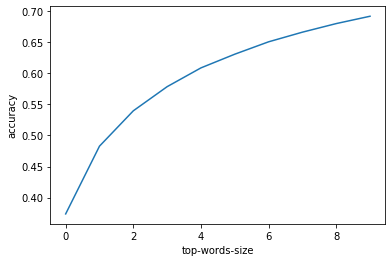

In [ ]:
#accuracies vs top 'n' words
n_acc={}
n_acc['accuracies']=[printing_outputs(transformer,validation_X[:10000],validation_Y[:10000],i+1) for i in range(10)] 
plt.plot(n_acc['accuracies'])
plt.ylabel('accuracy')
plt.xlabel('top-words-size')
plt.show()

In [ ]:
n_acc

{'accuracies': [0.3738,
  0.4827,
  0.5395,
  0.5783,
  0.6085,
  0.6305,
  0.6504,
  0.6659,
  0.6797,
  0.6915]}